<a href="https://colab.research.google.com/github/artisanvaultcode/predestrianRCNN/blob/main/Detecting_Pedestrians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!unzip -qo "/content/drive/MyDrive/PedestrianDataset.zip" -d "/content/drive/MyDrive/Pedestrians"

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
import numpy as np
import pandas as pd

import cv2
import os
from xml.etree import ElementTree
from matplotlib import pyplot as plt

In [88]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
keras = tf.keras

In [89]:
class_names = ['person','person-like']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

n_classes = 2
size = (120,120)

In [90]:
def load_data():
    datasets = ['/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Train/Train', '/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Test/Test', '/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Val/Val']
    output = []

    for dataset in datasets:
        imags = []
        labels = []
        directoryA = dataset +"/Annotations"
        directoryIMG = dataset +"/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:

            xmlf = os.path.join(directoryA,xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            imags.append(curr_img)
            i +=1

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

        labels = np.array(labels, dtype='int32')

        output.append((imags, labels))
    return output

In [91]:
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

In [92]:
train_images.shape

(944, 120, 120, 3)

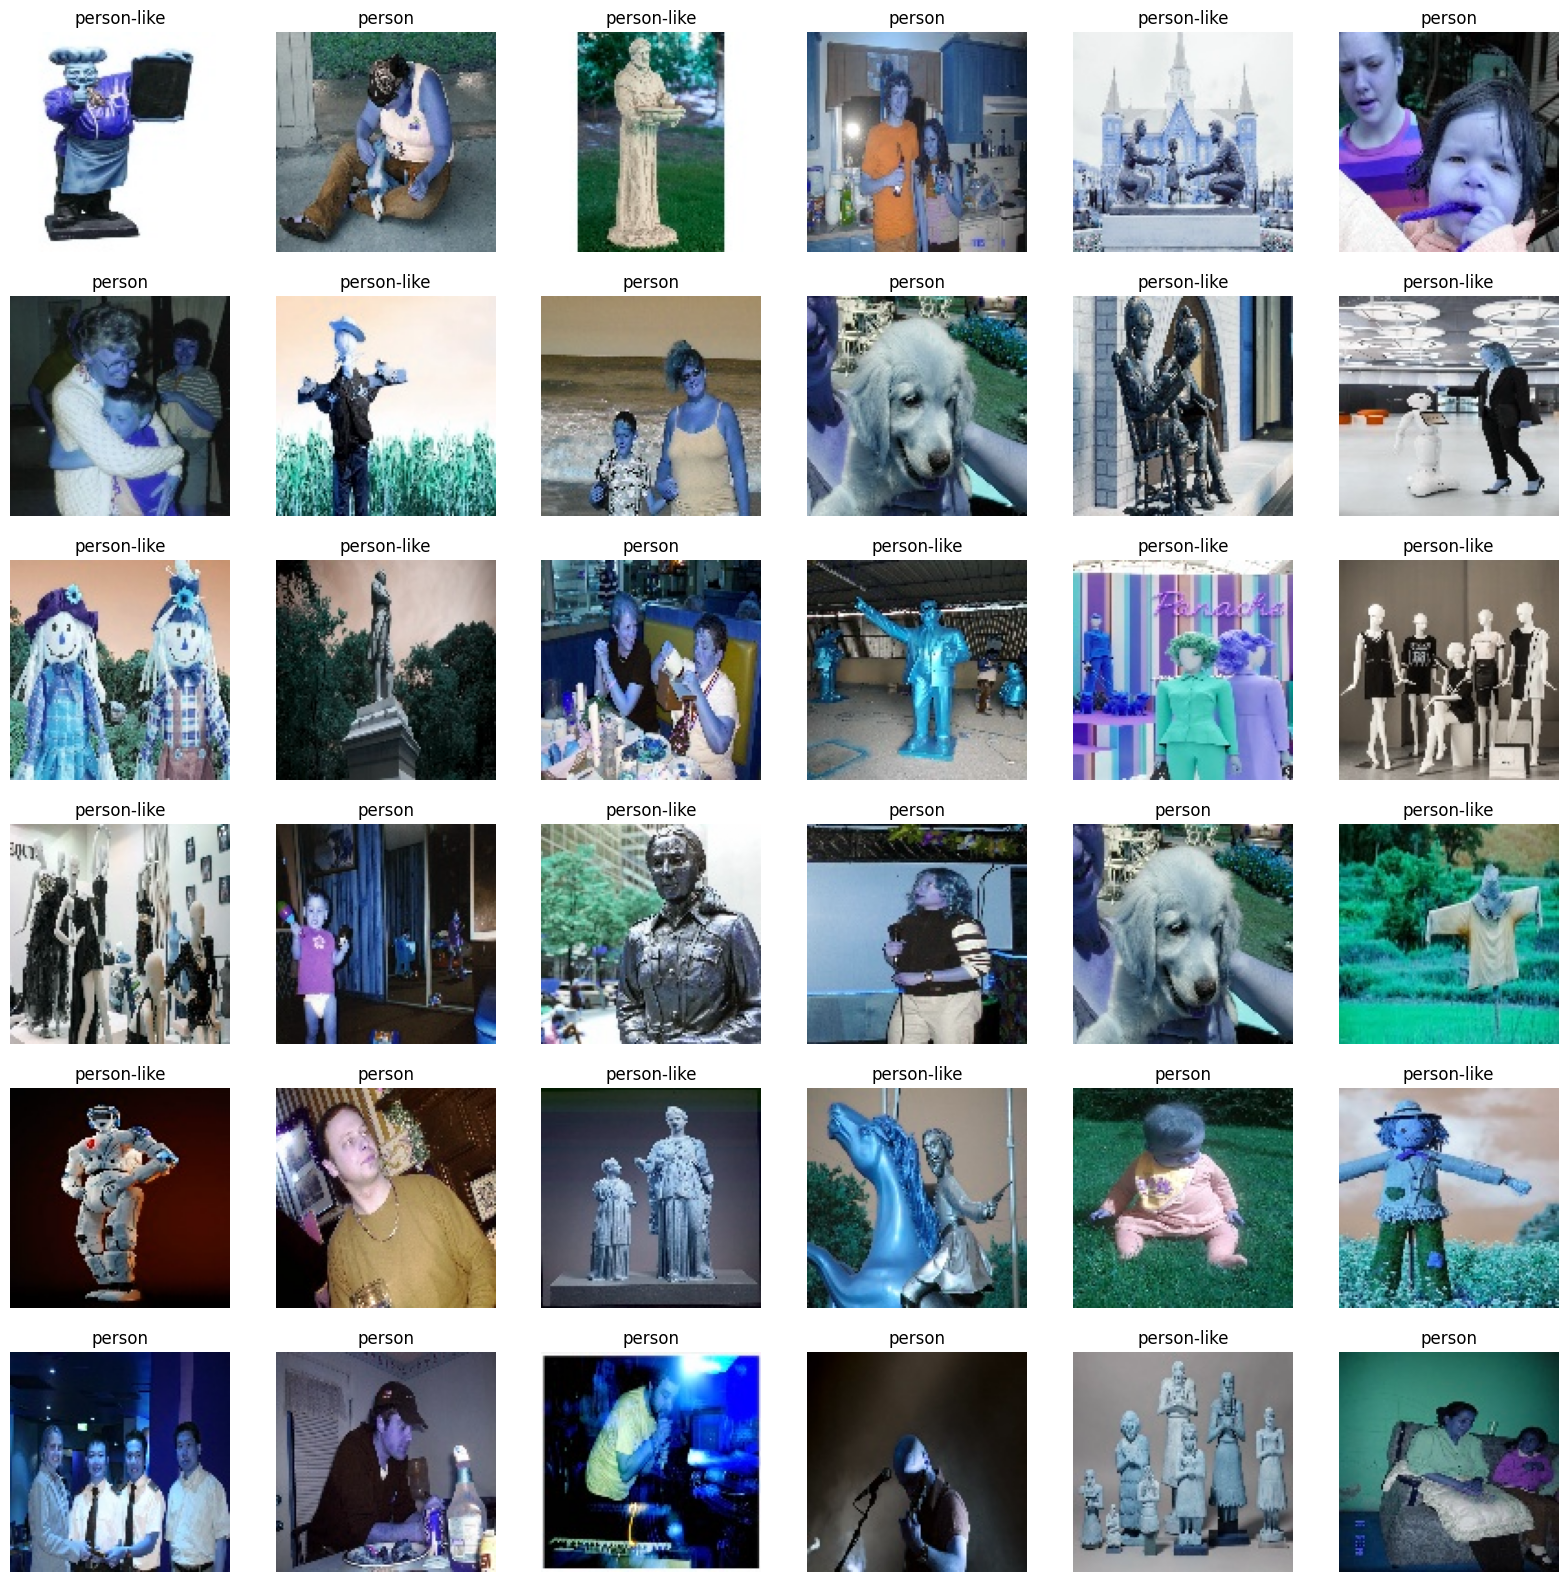

In [93]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')

In [94]:
# Instanciate a Sequential model. This allows us to create a new model layer by layer in a sequential manner.
model = models.Sequential()

# Add a 2D Convolutional layer with 4 filters, each of 5x5 dimensions.
# It uses ReLU (Rectified Linear Unit) activation function.
# This is used to scan the input image with (5x5) filters and 'relu' is used as an activation function to introduce non-linearity into the model.
# This is the first layer in the model, hence input_shape is provided which matches with the shape of each image in dataset.
model.add(layers.Conv2D(4, (5, 5), activation='relu', input_shape=(120, 120, 3)))

# Add a MaxPooling layer of pool size (2, 2). This is used to reduce the spatial dimensions (height & width) of input by taking maximum value within the window of (2, 2) at a time.
model.add(layers.MaxPooling2D((2, 2)))

# Add a 2D Convolutional layer with 12 filters of 2x2 size followed by a 'relu' activation function.
# This layer learns from the features extracted by previous convolutions, giving the model a deeper understanding of the input image.
model.add(layers.Conv2D(12, (2, 2), activation='relu'))

# Add another MaxPooling layer of pool size (2, 2).
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer is added to convert 2D or multidimensional data into a flat vector to be used as input to Dense layers.
model.add(layers.Flatten())

# A Dense layer with 16 units & 'relu' activation function which fully connects the input with 16 neurons.
model.add(layers.Dense(16, activation='relu'))

# Final Dense layer with 2 units. This is the output layer of the model. If this is used for binary classification you may want to add activation='softmax' for a probability distribution.
model.add(layers.Dense(2))

# Display a summary of the model, including layers and number of parameters.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 116, 116, 4)       304       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 58, 58, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 12)        204       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 12)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9408)              0         
                                                                 
 dense_4 (Dense)             (None, 16)               

optimizer='adam': This sets the optimizer for the model to Adam. Optimizers are algorithms used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Adam is an optimization algorithm that can handle sparse gradients on noisy problems.

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True): This sets the loss function to Sparse Categorical Crossentropy. In a classification problem, this computes the crossentropy loss between the labels and predictions. The from_logits=True attribute indicates that the prediction vectors are raw scores without any activation, and not probabilities. The activation function to convert these scores to probabilities is included in the loss function itself.

metrics=['accuracy']: The Metrics judged by the model in addition to the loss during training and validation. Accuracy is chosen, which computes the proportion of correct classifications made out of total classifications.

In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

1. from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
This line is importing the required callback classes from Keras.
2. es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=2)
EarlyStopping is a Keras callback to stop training when a monitored metric has stopped improving. Here, it is set to monitor the model's accuracy and will stop the training if accuracy is not improving for 2 (patience=2) consecutive epochs (an epoch is one full loop over the entire training dataset). The mode is set to 'max' which means training will stop when accuracy is no longer maximising.
3. filepath = "modelPedestrianDetection.h5"
This line sets the filepath where the model checkpoint will be saved.
4. ckpt = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
ModelCheckpoint is a Keras callback to save the Keras model during training. The model will only be saved at the filepath when the accuracy improves (save_best_only=True). If the accuracy doesn't improve, the model won't be saved. This ensures that we only save the best model.
5. rlp = ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1)
ReduceLROnPlateau is a Keras callback to reduce the learning rate when a metric has stopped improving which can help the model converge. Here, it is set to monitor the model's accuracy and will reduce the learning rate if accuracy is not improving for 2 (patience=2) consecutive epochs. verbose=1 means it will print an update message when the learning rate is reduced.

In [96]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=2)
filepath = "modelPedestrianDetection.h5"
ckpt = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
rlp = ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1)

1. train_images, train_labels: This is your training data. train_images are the inputs to your model and train_labels are the corresponding outputs.
2. epochs=60: This sets the number of epochs, which is the number of complete passes through the training dataset. In this case, the entire dataset will be passed forward and backward through the neural network 60 times.
3. validation_data=(test_images, test_labels): The validation_data parameter is used to evaluate the loss function and any model metrics at the end of each epoch on the provided dataset. The test_images and test_labels form the validation data in this case.
4. history = model.fit(...): model.fit() trains the model for a fixed number of epochs and returns a History object. This History object holds a record of the loss values and metric values during training.

In [98]:
# this line of code is running the training process for the model with a specified number of epochs and validation data. It saves the result of the training process to the history variable which can be used for later analysis or visualization of model performance over time.
history = model.fit(train_images, train_labels, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
30/30 [==============================] - 10s 335ms/step - loss: 0.6940 - accuracy: 0.5498 - val_loss: 0.6922 - val_accuracy: 0.5787
Epoch 2/10
30/30 [==============================] - 9s 288ms/step - loss: 0.6917 - accuracy: 0.5646 - val_loss: 0.6903 - val_accuracy: 0.5787
Epoch 3/10
30/30 [==============================] - 9s 306ms/step - loss: 0.6904 - accuracy: 0.5646 - val_loss: 0.6884 - val_accuracy: 0.5787
Epoch 4/10
30/30 [==============================] - 10s 328ms/step - loss: 0.6890 - accuracy: 0.5646 - val_loss: 0.6873 - val_accuracy: 0.5787
Epoch 5/10
30/30 [==============================] - 8s 267ms/step - loss: 0.6881 - accuracy: 0.5646 - val_loss: 0.6863 - val_accuracy: 0.5787
Epoch 6/10
30/30 [==============================] - 10s 331ms/step - loss: 0.6873 - accuracy: 0.5646 - val_loss: 0.6852 - val_accuracy: 0.5787
Epoch 7/10
30/30 [==============================] - 8s 266ms/step - loss: 0.6866 - accuracy: 0.5646 - val_loss: 0.6844 - val_accuracy: 0.5787
Epo

In [99]:
#saving the model for deployment and re-traning process
import joblib
joblib.dump(history, '/content/drive/MyDrive/Pedestrians/modelPedestrianDetectionAdam.pkl')

['/content/drive/MyDrive/Pedestrians/modelPedestrianDetectionAdam.pkl']

In [100]:
history = model.fit(train_images, train_labels, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
30/30 [==============================] - 10s 321ms/step - loss: 0.6854 - accuracy: 0.5646 - val_loss: 0.6826 - val_accuracy: 0.5787
Epoch 2/10
30/30 [==============================] - 11s 381ms/step - loss: 0.6853 - accuracy: 0.5646 - val_loss: 0.6821 - val_accuracy: 0.5787
Epoch 3/10
30/30 [==============================] - 8s 269ms/step - loss: 0.6851 - accuracy: 0.5646 - val_loss: 0.6819 - val_accuracy: 0.5787
Epoch 4/10
30/30 [==============================] - 10s 338ms/step - loss: 0.6850 - accuracy: 0.5646 - val_loss: 0.6818 - val_accuracy: 0.5787
Epoch 5/10
30/30 [==============================] - 9s 289ms/step - loss: 0.6850 - accuracy: 0.5646 - val_loss: 0.6817 - val_accuracy: 0.5787
Epoch 6/10
30/30 [==============================] - 9s 303ms/step - loss: 0.6849 - accuracy: 0.5646 - val_loss: 0.6816 - val_accuracy: 0.5787
Epoch 7/10
30/30 [==============================] - 10s 334ms/step - loss: 0.6849 - accuracy: 0.5646 - val_loss: 0.6815 - val_accuracy: 0.5787
Ep

In [101]:
# save for later deployment
import joblib
joblib.dump(history, '/content/drive/MyDrive/Pedestrians/modelPedestrianDetectionAdam1.pkl')

['/content/drive/MyDrive/Pedestrians/modelPedestrianDetectionAdam1.pkl']

In [102]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)

In [103]:
import numpy as np

X_train_vec = np.array([np.reshape(img, (-1,)) for img in train_images])

In [104]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

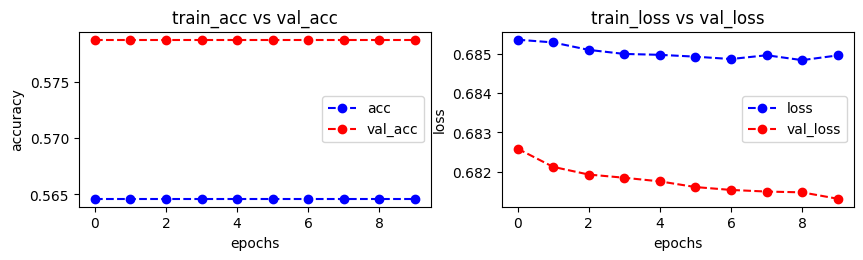

In [105]:
plot_accuracy_loss(history)

In [106]:
preds = model.predict(val_images)

5/5 [==============================] - 1s 88ms/step


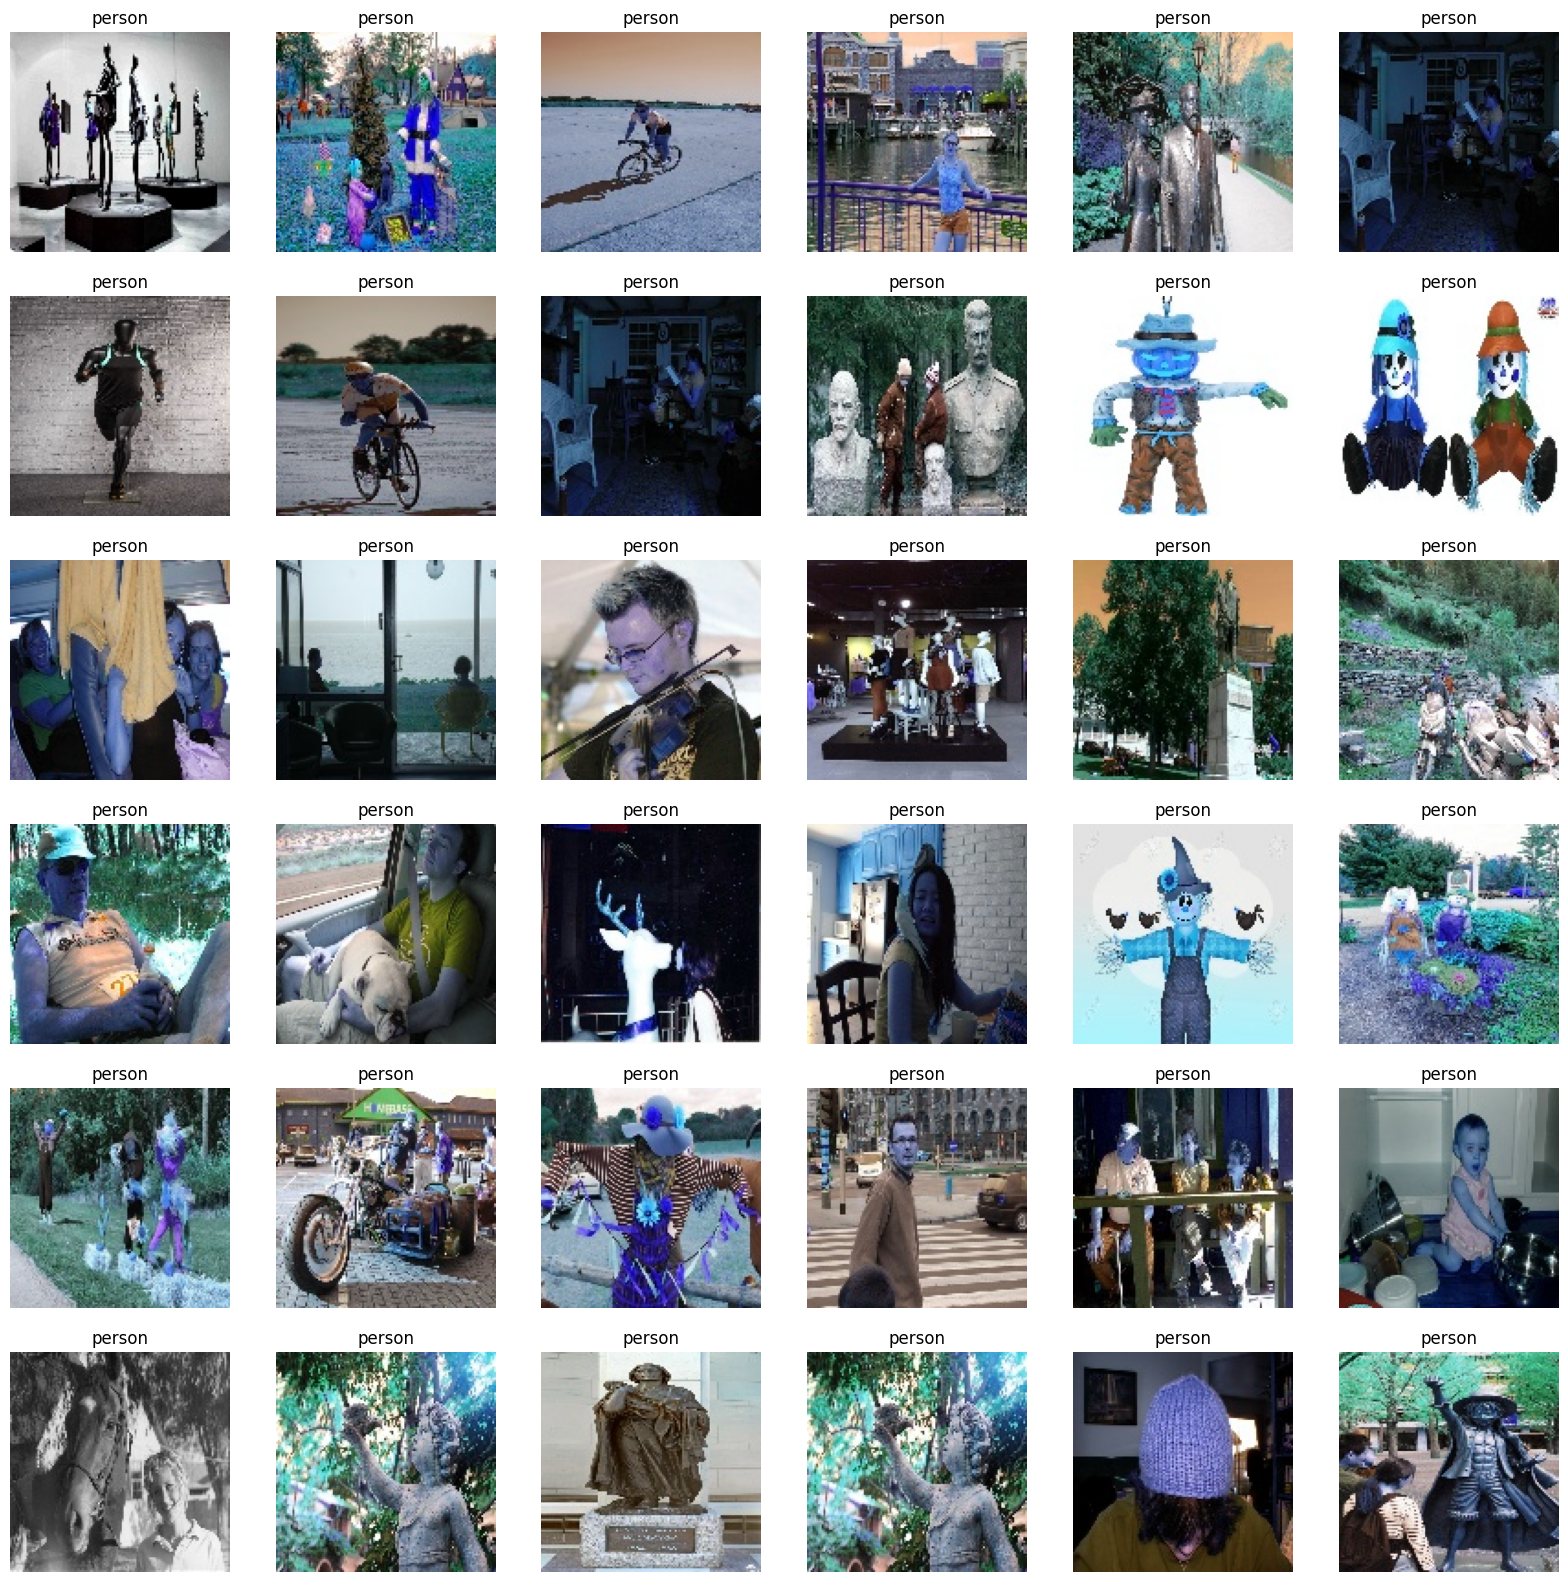

In [107]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(val_images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(val_images[i])
    plt.axis('off')
    x =np.argmax(preds[i]) # takes the maximum of of the 6 probabilites.
    plt.title((class_names[x]))

In [108]:
result = []
for i in range(len(preds)):
    result.append(np.argmax(preds[i]))

In [109]:
tn, fp, fn, tp = confusion_matrix(val_labels,result).ravel()

In [110]:
(tn, fp, fn, tp)

(85, 0, 75, 0)

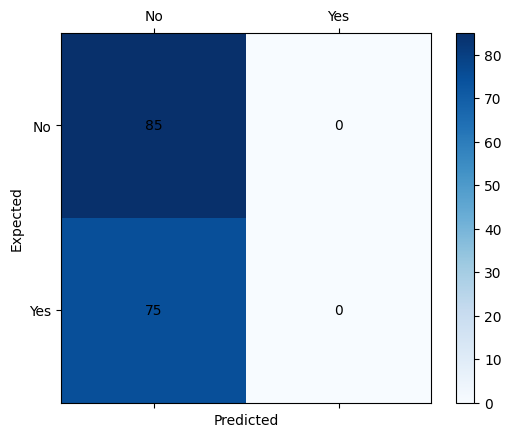

In [111]:
conf_mat = confusion_matrix(val_labels,result)

fig, ax = plt.subplots()
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Draw the grid lines for the matrix
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center')

plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks([0, 1], ['No', 'Yes'])
plt.show()

In [112]:
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    *model.evaluate(test_images, test_labels, verbose=2))
)

8/8 - 1s - loss: 0.6813 - accuracy: 0.5787 - 687ms/epoch - 86ms/step
Final loss: 0.6813, final accuracy: 0.5787
